In [1]:
from datetime import datetime
import pandas as pd
import glob


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

In [2]:
FORM = "%H:%M:%S.%f"

In [3]:
clean_df = None    

# Clean dataframe txt (azure time is 2 hours behind on local time)
execute = pd.read_csv(f"benchmark_runs/timings-2023-07-03-pagerank-68.txt", sep=" ", header=None)
execute.columns = ["Date", "Time"]
# Start = the tenant program in the container start working
# Dataframe = the tenant dataframe is created and can be executed
# Finished = The tenant program has been executed and results are saved
execute.insert(0, "Action", ["start", "dataframe", "finished"])
execute["Time"] = execute["Time"] + pd.Timedelta(hours=2)
execute["Time"] = execute["Time"].astype(str).replace("0 days ", "", regex=True)
execute = execute.drop('Date', axis=1)

# Clean dataframe
run = pd.read_csv(f"benchmark_runs/tenantb-pagerank-68-2023-07-03-pull-images.csv")
run = run.drop('Date', axis=1)

# Calcultate the duration
creation = datetime.strptime(run.iloc[1]["Time"], FORM) - datetime.strptime(run.iloc[0]["Time"], FORM)
tenant_program_start = datetime.strptime(execute.iloc[0]["Time"], FORM) - datetime.strptime(run.iloc[2]["Time"], FORM)
tenant_program_dataframe_creation = datetime.strptime(execute.iloc[1]["Time"], FORM) - datetime.strptime(execute.iloc[0]["Time"], FORM)
tenant_program_execution = datetime.strptime(execute.iloc[2]["Time"], FORM) - datetime.strptime(execute.iloc[1]["Time"], FORM)
execution = datetime.strptime(run.iloc[3]["Time"], FORM) - datetime.strptime(run.iloc[2]["Time"], FORM)
deletion = datetime.strptime(run.iloc[5]["Time"], FORM) - datetime.strptime(run.iloc[4]["Time"], FORM)

# Create readable dataframe
result_total = pd.DataFrame([creation, execution, deletion, tenant_program_start, tenant_program_dataframe_creation, tenant_program_execution])
result_total.columns = ["Time"]
result_total.index = ["creation", "execution", "deletion", "tpstart", "tpdataframe", "tpfinished"]
result_total["Time"] = result_total["Time"].astype(str).replace("0 days ", "", regex=True)
result_total = result_total.transpose()


clean_df = result_total

clean_df

creation        execution         deletion          tpstart  \
Time  00:00:53.726275  00:03:29.269576  00:00:40.206875  00:00:53.393955   

          tpdataframe       tpfinished  
Time  00:01:43.196741  00:00:52.076869

In [4]:
df = clean_df
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

columns_to_update = ["creation", "execution", "deletion", "tpstart", "tpdataframe", "tpfinished"]
for _ in columns_to_update:
    updated_values = []
    for row in df[_]:
        h,m,s = row.split(":")
        s = s.split(".")[0]
        total_s = (int(h) * 3600) + (int(m) * 60) + int(s)
        updated_values.append(total_s)
    df[f"{_}_seconds"] = updated_values

df['total'] = df["creation_seconds"] + df["execution_seconds"]  + df["deletion_seconds"]
df["execution_remainder"] = df["execution_seconds"] - df["tpstart_seconds"] - df["tpdataframe_seconds"] - df["tpfinished_seconds"]
df.index = ["images pulled"]
df

creation        execution         deletion  \
images pulled  00:00:53.726275  00:03:29.269576  00:00:40.206875   

                       tpstart      tpdataframe       tpfinished  \
images pulled  00:00:53.393955  00:01:43.196741  00:00:52.076869   

               creation_seconds  execution_seconds  deletion_seconds  \
images pulled                53                209                40   

               tpstart_seconds  tpdataframe_seconds  tpfinished_seconds  \
images pulled               53                  103                  52   

               total  execution_remainder  
images pulled    302                    1

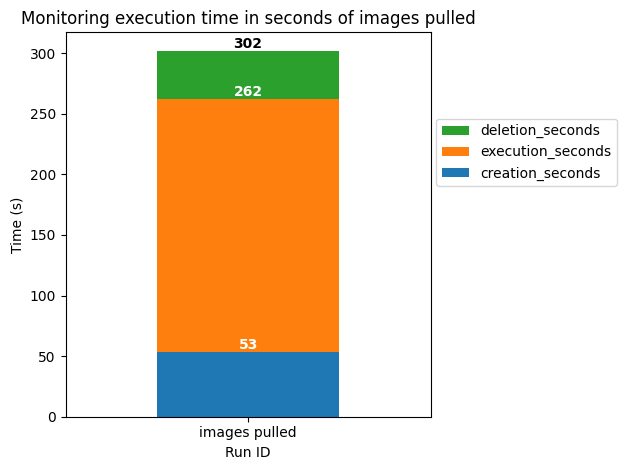

In [8]:
identifier = "images pulled"
selected_columns = ["creation_seconds", "execution_seconds", "deletion_seconds"]
overall = df[selected_columns]
ax = overall.plot(kind="bar", stacked=True, rot=0)

# Add Title and Labels
plt.title(f"Monitoring execution time in seconds of {identifier}")
plt.xlabel("Run ID")
plt.ylabel("Time (s)")
# ax.legend(bbox_to_anchor=(1.0, 1.0))
for i, item in enumerate(reversed(ax.containers)):
    c = "black" if i == 0 else "white"
    # if i == 0:
    ax.bar_label(item, color=c, weight="bold")
plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=(1.015,0.6))
plt.tight_layout() 
plt.savefig(f"benchmark_runs/total_execution.png")

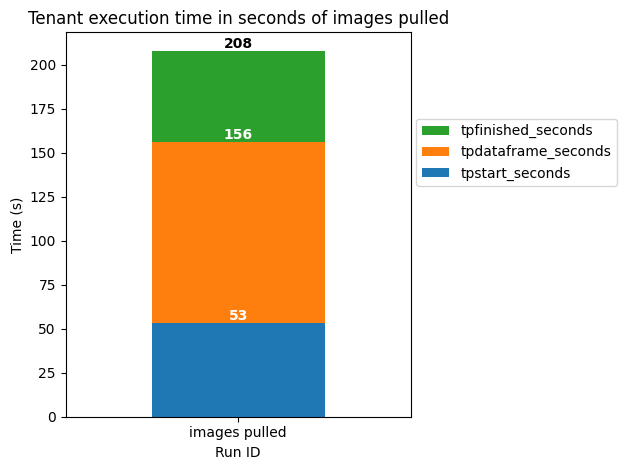

In [18]:
selected_columns_tp = ["tpstart_seconds", "tpdataframe_seconds", "tpfinished_seconds"]
tp = df[selected_columns_tp]
ax2 = tp.plot(kind="bar", stacked=True, rot=0)

# Add Title and Labels
plt.title(f"Tenant execution time in seconds of {identifier}")
plt.xlabel("Run ID")
plt.ylabel("Time (s)")
for i, item in enumerate(reversed(ax2.containers)):
    c = "black" if i == 0 else "white"
    # if i == 0:
    ax2.bar_label(item, color=c, weight="bold")
plt.tight_layout()
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc=(1.015,0.6))
plt.tight_layout()
plt.savefig(f"benchmark_runs/tenant_program.png")

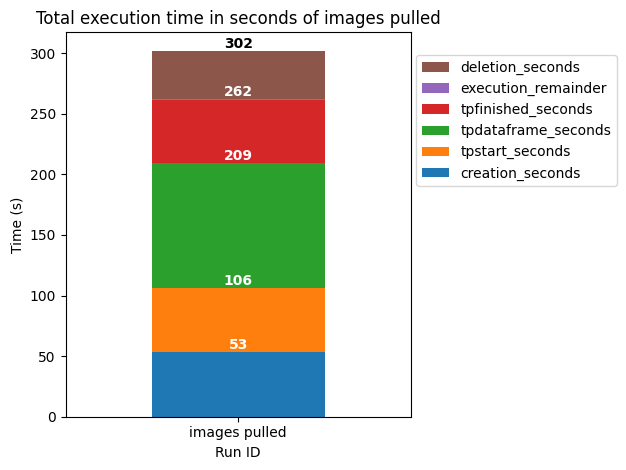

In [19]:

selected_combined = ["creation_seconds", "tpstart_seconds", "tpdataframe_seconds", "tpfinished_seconds", "execution_remainder", "deletion_seconds"]
combined = df[selected_combined]
r_selected_combined = selected_combined.copy()
r_selected_combined.reverse()

ax3 = combined.plot(kind="bar", stacked=True, legend=False, rot=0)
# Add Title and Labels
plt.title(f"Total execution time in seconds of {identifier}")
plt.xlabel("Run ID")
plt.ylabel("Time (s)")
# ax3.legend(bbox_to_anchor=(1.0, 1.0))
for i, item in enumerate(reversed(ax3.containers)):
    if i != 2:
        c = "black" if i == 0 else "white"
        ax3.bar_label(item, color=c, weight="bold")
plt.tight_layout()
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles[::-1], labels[::-1], loc=(1.015,0.6))
plt.tight_layout()
plt.savefig(f"benchmark_runs/combined.png")